In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr
import pickle

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline
plt.style.use('bmh')
import matplotlib as mpl
import seaborn as sns
from xgboost import plot_importance

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
#!pip install statsmodels
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
#!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [2]:
store = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
test = pd.read_csv("test.csv")

## 1. Data and merging 3 dataframes 
>(store, train, features)

In [3]:
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Merging all 3 datasets


In [6]:
data = train.merge(features, 
                    on=['Store', 'Date'], 
                    how='inner').merge(store, on=['Store'], 
                                       how='inner')
data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [8]:
if data["IsHoliday_x"].all()==data["IsHoliday_y"].all():
    data.drop("IsHoliday_y",axis=1,inplace=True)
    data.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [9]:
#Converting Date from object to datetime datatype
data["Date"] = pd.to_datetime(data["Date"])
data["year"] = data["Date"].dt.year
data["month"] = data["Date"].dt.month
data["week"] = data["Date"].dt.week

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

## Stores and Department statistics

In [11]:
print("Total number of stores = ",data["Store"].nunique())
print("Total number of departments = ",data["Dept"].nunique())

Total number of stores =  45
Total number of departments =  81


### Dealing with wrong data

As Weekly sales cannot be negative, we would choose and remove it if the no. of observations is less 0.5 of our dataframe

In [12]:
data.loc[data["Weekly_Sales"]<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2010,2,7
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315,2010,3,10
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315,2010,10,40
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315,2011,1,3
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315,2011,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221,2012,5,21
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221,2012,6,26
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221,2012,8,31
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221,2012,8,35


As there are 1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [13]:
#Updating data
data = data.loc[data["Weekly_Sales"]>0]

In [14]:
data.shape

(420212, 19)

## Date period

In [15]:
# Showing first 3 and last 3 rows 
data["Date"].head(3).append(data["Date"].tail(3))

0        2010-02-05
1        2010-02-05
2        2010-02-05
421567   2012-10-26
421568   2012-10-26
421569   2012-10-26
Name: Date, dtype: datetime64[ns]

Our data is from 5th February 2010 to 26th October 2012.

## Holidays column

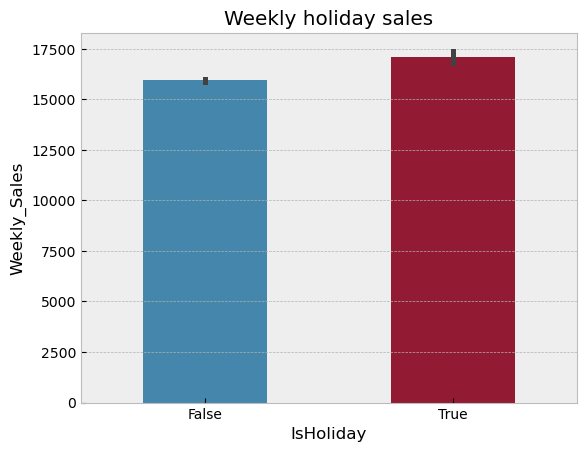

In [26]:
sns.barplot(x="IsHoliday",y="Weekly_Sales",data=data,width=0.5);
plt.title("Weekly holiday sales");

## Weekly sales report according to types and holidays

In [17]:
data.groupby(["IsHoliday","Type"])["Weekly_Sales"].mean()

IsHoliday  Type
False      A       20058.212098
           B       12204.870740
           C        9548.251972
True       A       21332.892028
           B       13423.406047
           C        9565.533649
Name: Weekly_Sales, dtype: float64

### Percentage of store types

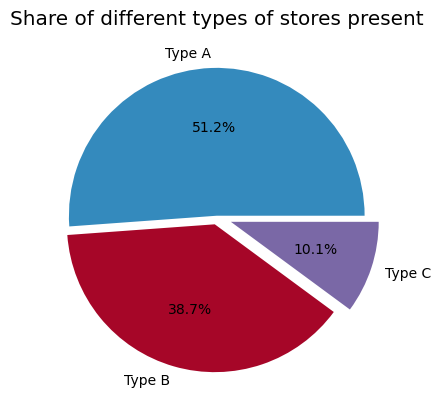

In [18]:
perc = data["Type"].value_counts()*100/len(data["Type"])
labels = data["Type"].unique()
for i in range(0,len(labels)):
    labels[i]="Type "+labels[i]
plt.pie(perc,labels=labels,explode=[0.01,0.05,0.1],autopct="%1.1f%%");
plt.title("Share of different types of stores present");

Nearly 50% of stores belong to Type A !

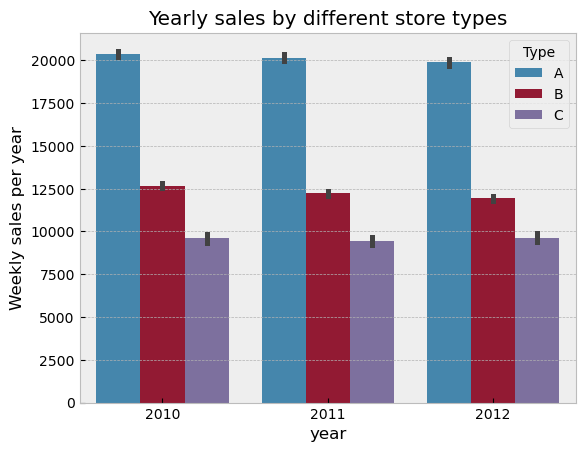

In [19]:
sns.barplot(x="year",y="Weekly_Sales",hue="Type",data=data)
plt.ylabel("Weekly sales per year")
plt.title('Yearly sales by different store types');

### Unemployment rate in different store types

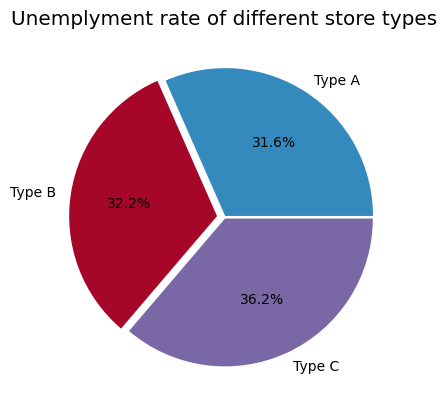

In [20]:
unemployment_rate = data.groupby(["Type"])["Unemployment"].mean()*100/sum(data.groupby(["Type"])["Unemployment"].mean())
labels = data["Type"].unique()
for i in range(0,len(labels)):
    labels[i]="Type "+labels[i]
plt.pie(unemployment_rate,labels=labels, 
        explode=[0.01,0.05,0.01],autopct="%1.1f%%");
plt.title("Unemplyment rate of different store types");

## Department sales

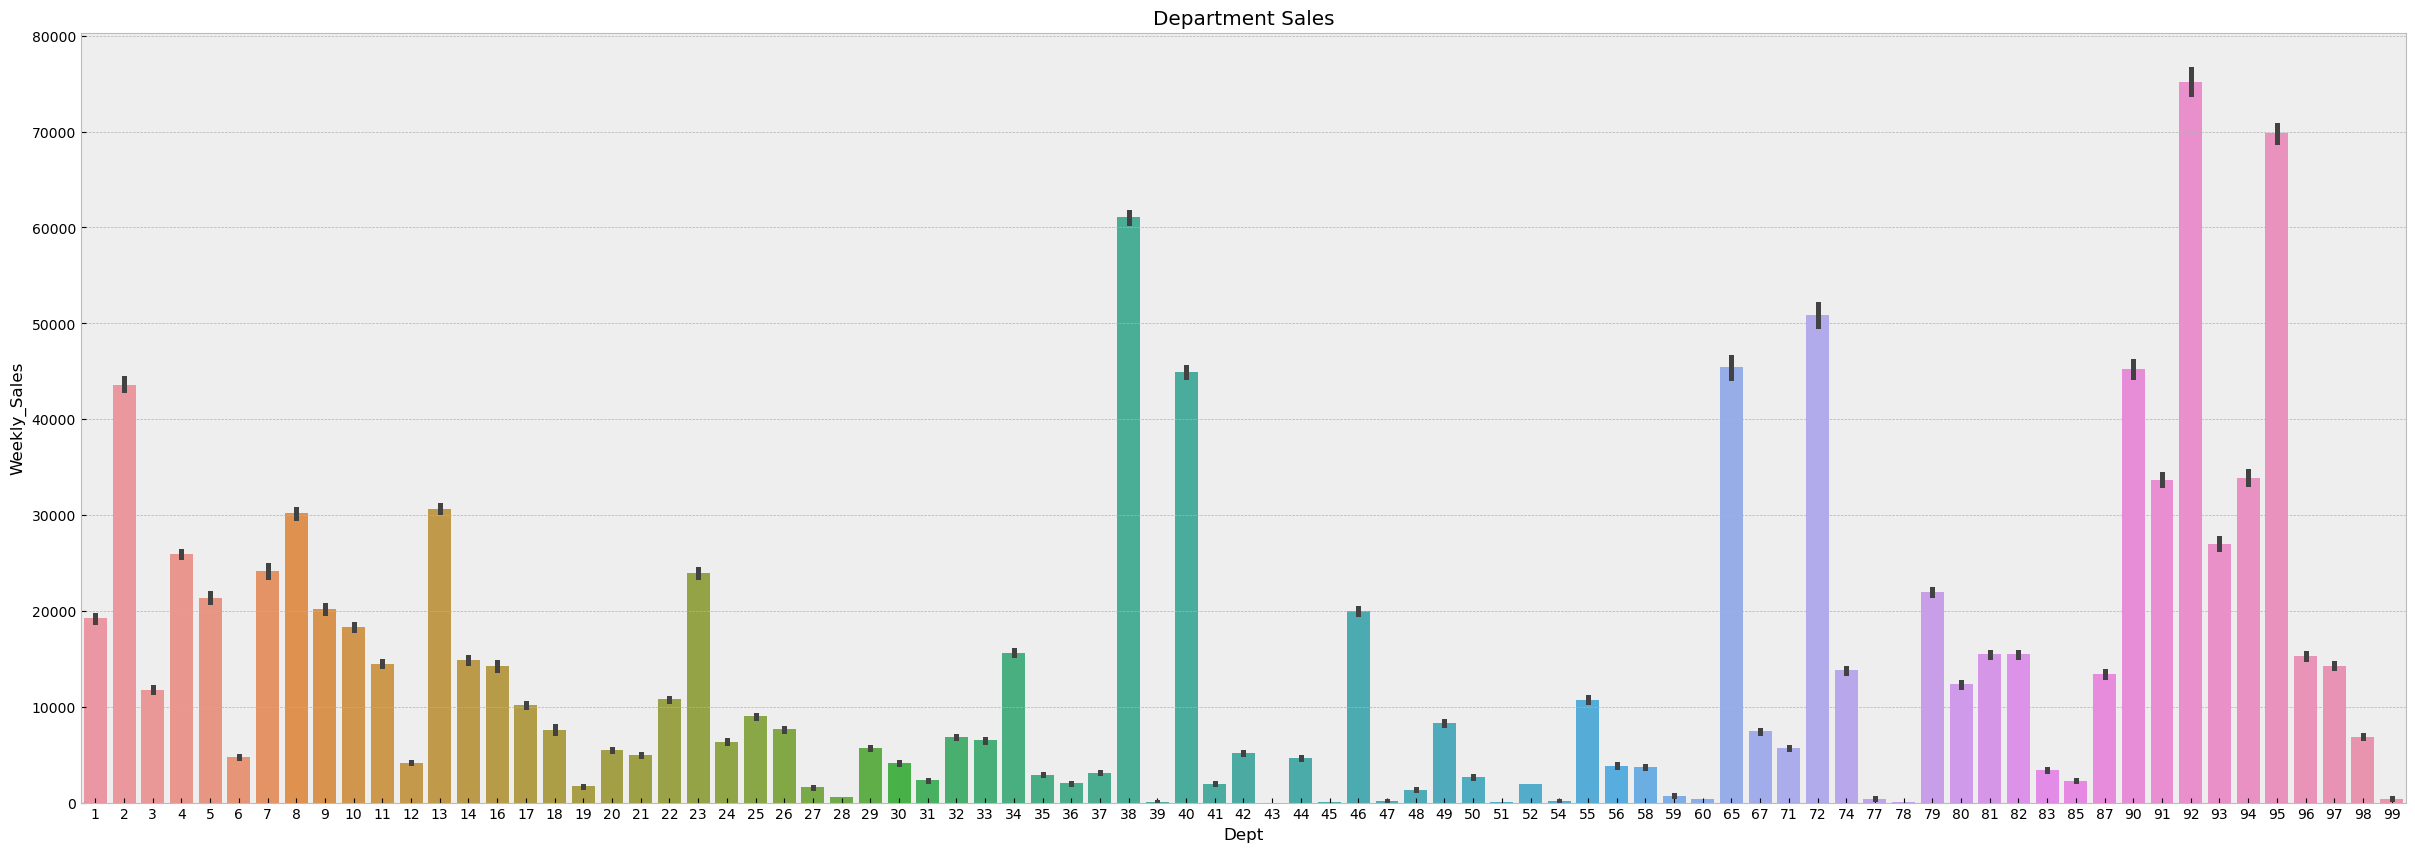

In [21]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x="Dept",y="Weekly_Sales",data=data);
plt.title("Department Sales");

## Store sales

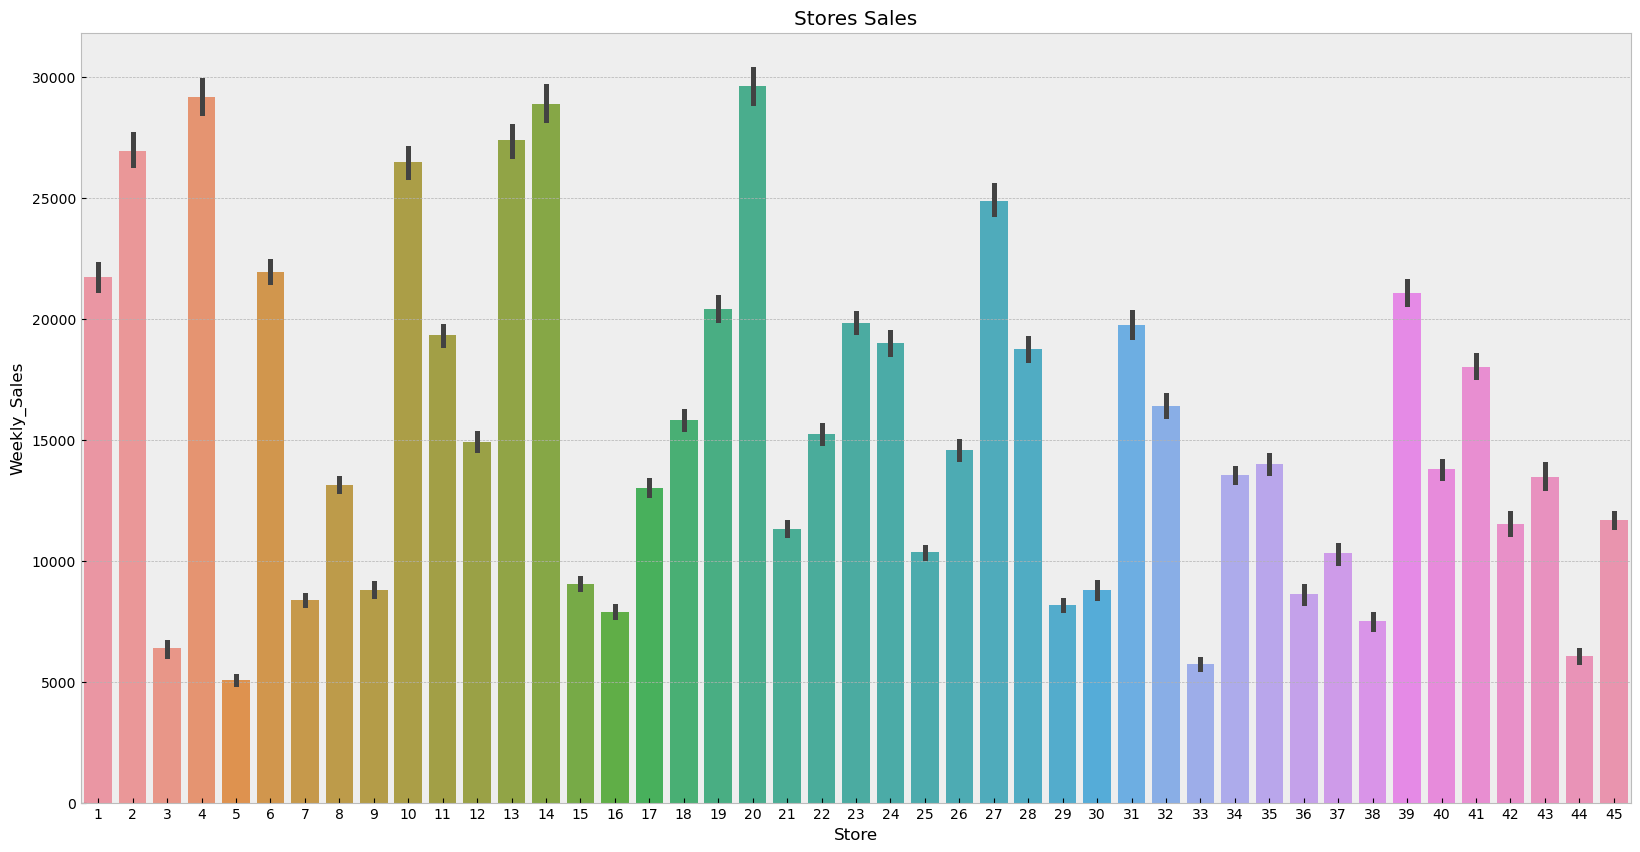

In [22]:
plt.figure(figsize=(20,10))
fig = sns.barplot(x="Store",y="Weekly_Sales",data=data);
plt.title("Stores Sales");

## Monthly sales

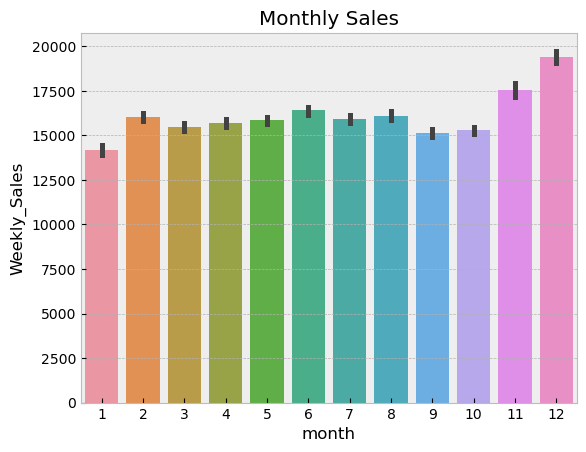

In [27]:
sns.barplot(x='month',y='Weekly_Sales',data=data)
plt.title("Monthly Sales");

<Figure size 600x400 with 0 Axes>

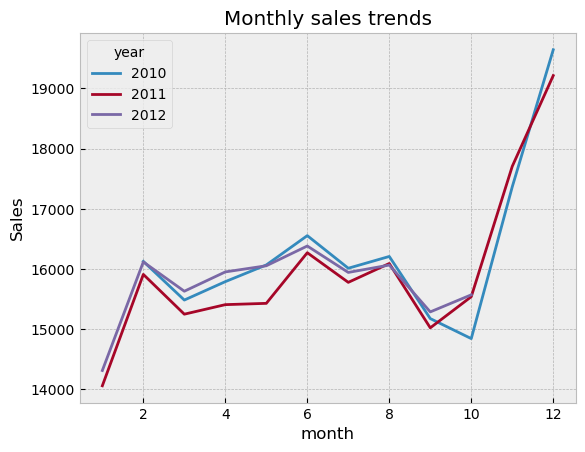

In [28]:
monthly_sales = pd.pivot_table(data, values = "Weekly_Sales", columns = "year", index = "month")
plt.figure(figsize=(6,4));
monthly_sales.plot();
plt.title("Monthly sales trends");
plt.ylabel("Sales");

As it is seen
> There are peaks in 4 months (Feb, June, Aug, Dec)
* We donot have the data of Jan in the year 2010 and Dec in the year 2012
* December achieves the highest sales each year.

## Weekly Sales

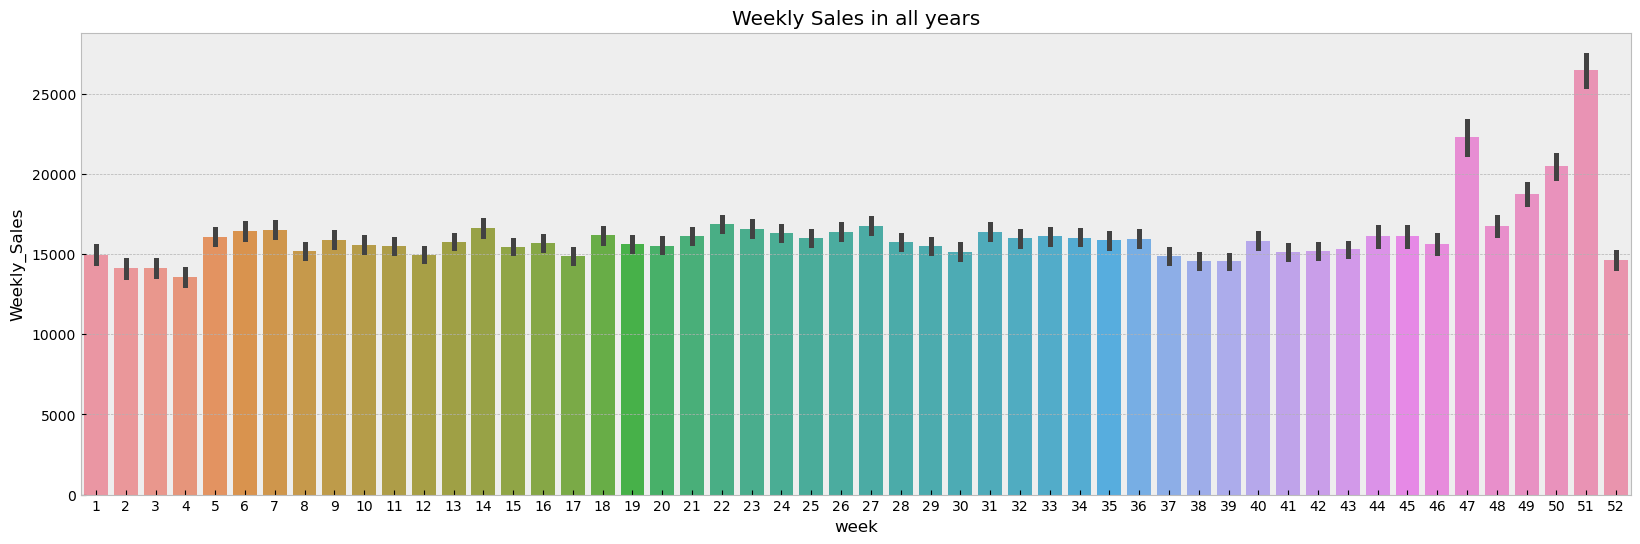

In [29]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=data)
plt.title("Weekly Sales in all years");

Mid November & Second last week of December (Pre Christmas Week) recorded the highest sales combining all 3 years of data

### Trends of weekly sales year-wise

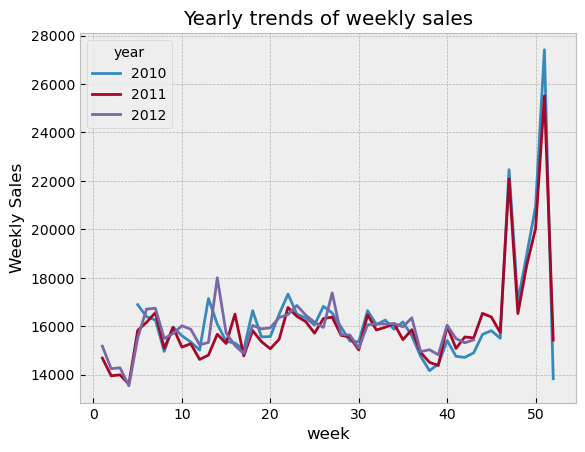

In [30]:
weekly_sales = pd.pivot_table(data, values = "Weekly_Sales", 
                              columns = "year", index = "week");
weekly_sales.plot();
plt.title("Yearly trends of weekly sales");
plt.ylabel("Weekly Sales");

# Features effects on Weekly Sales

### 1. Temperature

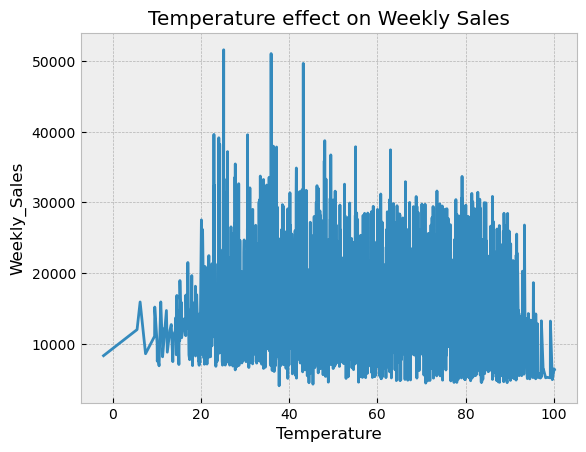

In [31]:
sns.lineplot(x="Temperature",y="Weekly_Sales",data=data,ci=None)
plt.title("Temperature effect on Weekly Sales");

### 2. Fuel Price

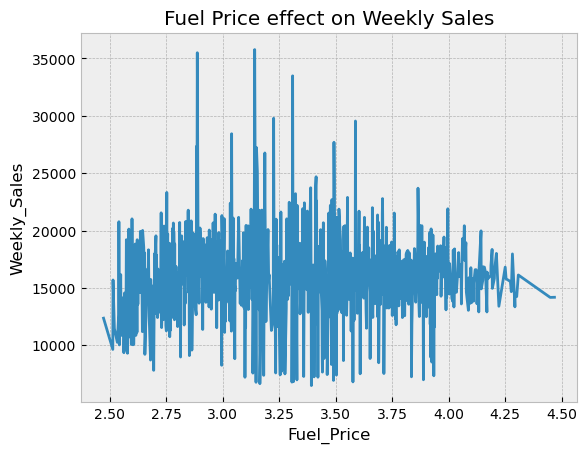

In [32]:
sns.lineplot(x="Fuel_Price",y="Weekly_Sales",data=data,ci=None)
plt.title("Fuel Price effect on Weekly Sales");

### 3. CPI (Consumer Price Index)

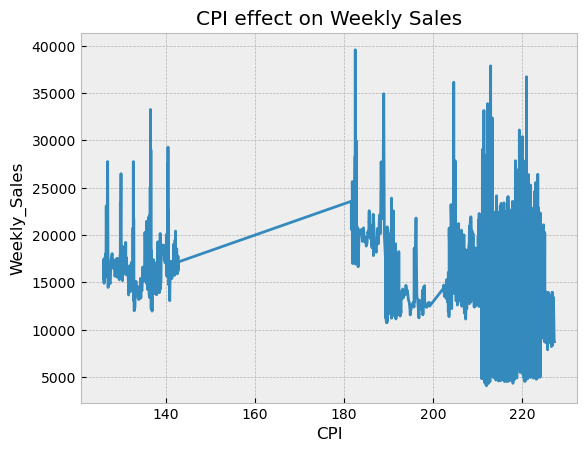

In [33]:
sns.lineplot(x="CPI",y="Weekly_Sales",data=data,ci=None);
plt.title("CPI effect on Weekly Sales");

### 4. Store size

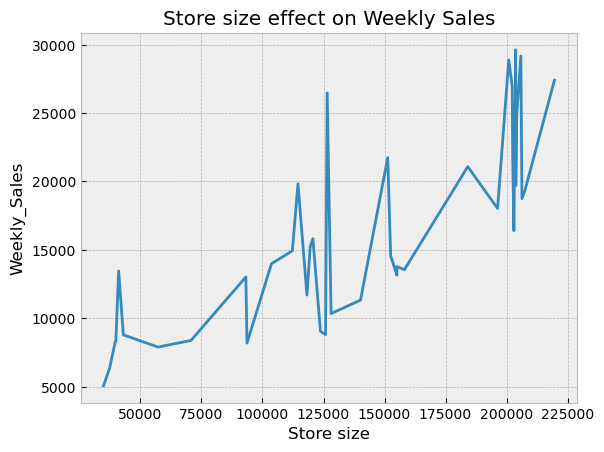

In [34]:
sns.lineplot(x="Size",y="Weekly_Sales",data=data,ci=None);
plt.title("Store size effect on Weekly Sales");
plt.xlabel("Store size");

# 2. Data Preprocessing in train dataset

#### Filling NULL values

In [8]:
train.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

No NULL values present

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


#### Changing all non-integer datatypes to integers

Distributing Date column into Year, Month columns

In [10]:
train["Date"] = pd.to_datetime(train["Date"])
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["week"] = train["Date"].dt.week
train["day"] = train["Date"].dt.day

Replacing bool as int in IsHoliday column

> * T : 1 
> * F : 0

In [14]:
train["IsHoliday"] = train["IsHoliday"].astype("int64")

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   year          421570 non-null  int64         
 6   month         421570 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 22.5 MB


# 3. Features Selection

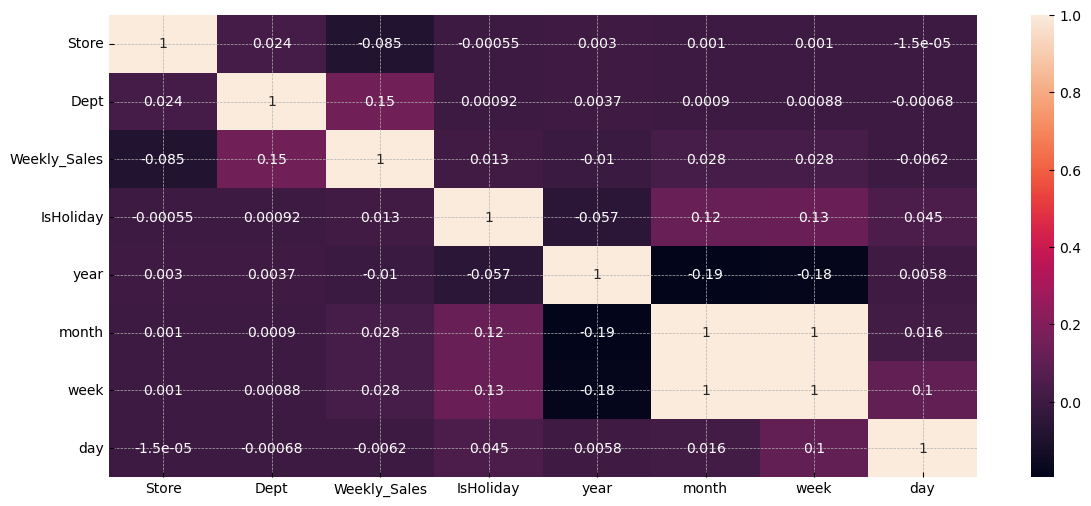

In [214]:
# To find correlation between different columns
cor=train.corr()
plt.figure(figsize=(14,6))
sns.heatmap(cor,annot=True);

In [217]:
x_fit = train.drop(['Weekly_Sales',"Date"],axis=1)
y_fit = train['Weekly_Sales']
x_best= SelectKBest(f_regression, k=7).fit(x_fit, y_fit)
mask = x_best.get_support()
features_selection = [] 
for bool, feature in zip(mask, x_fit.columns):
    if bool:
        features_selection.append(feature)
print('\nBest Features to be worked with are :{}\n\n'.format(features_selection)) # The list of your 5 best feature


Best Features to be worked with are :['Store', 'Dept', 'IsHoliday', 'year', 'month', 'week', 'day']




# 4. Training our model

Before we train model,I am creating a function to give us all the evaluation metrics in one go

In [154]:
def evaluate(y_preds,y_test,model):
    global x_test
    print("Accuracy achieved : ",round(model.score(x_test,y_test)*100,2),"%")
    print("Mean absolute error : ",mean_absolute_error(y_preds,y_test))
    print("Root mean squared error : ",np.sqrt(mean_squared_error(y_preds,y_test)))
    
def evaluation(y_preds,y_test,model):
    global x_test
    l=[]
    l.append(round(model.score(x_test,y_test)*100,3))
    l.append(mean_absolute_error(y_preds,y_test))
    l.append(np.sqrt(mean_squared_error(y_preds,y_test)))
    return l;

### a) RandomForestRegressor

In [ ]:
# Selecting features and target variables x and y
x = train.drop(["Date","Weekly_Sales"],axis=1)
y = train["Weekly_Sales"]

#set up random seed
np.random.seed(42)

#create training and testing sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

# Training our model 
model3 = RandomForestRegressor()
model3.fit(x_train,y_train)

In [ ]:
y_preds = model3.predict(x_test)
evaluate(y_preds,y_test,model3)

#### Tuning using RndomizedSearchCV

In [222]:
params = {'n_estimators':[10,50],
         'max_depth':range(8,15),
         'random_state':[7,42]}

rf_model = RandomizedSearchCV(model3,params,n_iter=7,verbose=2)
rf_model.fit(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .....max_depth=10, n_estimators=10, random_state=42; total time=   9.8s
[CV] END .....max_depth=10, n_estimators=10, random_state=42; total time=   9.6s
[CV] END .....max_depth=10, n_estimators=10, random_state=42; total time=   9.7s
[CV] END .....max_depth=10, n_estimators=10, random_state=42; total time=   9.4s
[CV] END .....max_depth=10, n_estimators=10, random_state=42; total time=   9.4s
[CV] END ......max_depth=13, n_estimators=10, random_state=7; total time=  12.2s
[CV] END ......max_depth=13, n_estimators=10, random_state=7; total time=  13.0s
[CV] END ......max_depth=13, n_estimators=10, random_state=7; total time=  13.2s
[CV] END ......max_depth=13, n_estimators=10, random_state=7; total time=  11.9s
[CV] END ......max_depth=13, n_estimators=10, random_state=7; total time=  11.9s
[CV] END ......max_depth=11, n_estimators=10, random_state=7; total time=  10.3s
[CV] END ......max_depth=11, n_estimators=10, ran

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=7,
                   param_distributions={'max_depth': range(8, 15),
                                        'n_estimators': [10, 50],
                                        'random_state': [7, 42]},
                   verbose=2)

In [223]:
rf_model.best_params_

{'random_state': 42, 'n_estimators': 50, 'max_depth': 14}

In [224]:
y_rs_preds = rf_model.predict(x_test)
evaluate(y_rs_preds,y_test,rf_model)

Accuracy achieved :  91.1 %
Mean absolute error :  3199.7023126810277
Root mean squared error :  6812.2856016734


### b) XGBoostRegressor

In [225]:
# Selecting features and target variables x and y
x = train.drop(["Date","Weekly_Sales"],axis=1)
y = train["Weekly_Sales"]

#set up random seed
np.random.seed(42)

#create training and testing sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

# Training our model 
model2 = XGBRegressor()
model2.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [227]:
y_xg_preds = model2.predict(x_test)
evaluate(y_xg_preds,y_test,model2)

Accuracy achieved :  92.53 %
Mean absolute error :  3697.827933372447
Root mean squared error :  6240.096413215108


In [228]:
params = {'n_estimators':[10,50],
         'max_depth':range(8,15),
         'random_state':[7,42]}

xg_gs_model = RandomizedSearchCV(model2,params,n_iter=7,verbose=2)
xg_gs_model.fit(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ......max_depth=14, n_estimators=10, random_state=7; total time=   4.1s
[CV] END ......max_depth=14, n_estimators=10, random_state=7; total time=   4.1s
[CV] END ......max_depth=14, n_estimators=10, random_state=7; total time=   3.9s
[CV] END ......max_depth=14, n_estimators=10, random_state=7; total time=   4.2s
[CV] END ......max_depth=14, n_estimators=10, random_state=7; total time=   4.0s
[CV] END .....max_depth=13, n_estimators=50, random_state=42; total time=  17.6s
[CV] END .....max_depth=13, n_estimators=50, random_state=42; total time=  20.8s
[CV] END .....max_depth=13, n_estimators=50, random_state=42; total time=  18.7s
[CV] END .....max_depth=13, n_estimators=50, random_state=42; total time=  19.6s
[CV] END .....max_depth=13, n_estimators=50, random_state=42; total time=  19.7s
[CV] END ......max_depth=13, n_estimators=50, random_state=7; total time=  19.2s
[CV] END ......max_depth=13, n_estimators=50, ran

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=7,
                   param_distributions={'max_depth': range(8, 15),
                                        'n_estimators': [10, 50],
                                        'random_state': [7, 42]},
                   verbose=2)

In [229]:
xg_gs_model.best_params_

{'random_state': 42, 'n_estimators': 50, 'max_depth': 13}

In [230]:
y_xg_rs_preds = xg_gs_model.predict(x_test)
evaluate(y_xg_rs_preds,y_test,xg_gs_model)

Accuracy achieved :  98.04 %
Mean absolute error :  1468.2485915339653
Root mean squared error :  3199.8135507144757


### Comparing all 4 models used

In [231]:
compare = pd.DataFrame(data={"RandomForest":evaluation(y_preds,y_test,model3),
                                "RandomForest(with tuning)":evaluation(y_gs_preds,y_test,rf_model),
                               "XGBRegressor":evaluation(y_xg_preds,y_test,model2),
                               "XGBRegressor(with tuning)":evaluation(y_xg_rs_preds,y_test,xg_gs_model)},
                       index=["Accuracy achieved",
                              "Mean Absolute error",
                              "Root Mean squared error"])
compare

,RandomForest,RandomForest(with tuning),XGBRegressor,XGBRegressor(with tuning)
Accuracy achieved,97.249000,91.101000,92.533000,98.037000
Mean Absolute error,1363.432051,3972.617232,3697.827933,1468.248592
Root Mean squared error,3787.225992,8364.809920,6240.096413,3199.813551


From our results :
>*  XGBRregressor along with parameters
>* {'random_state': 42, 'n_estimators': 50, 'max_depth': 13}
is the best regressor

### Model chosen is XGBRegressor

## Feature importance in chosen model

In [232]:
imp = XGBRegressor(random_state= 42, 
                   n_estimators= 50, 
                   max_depth= 13)
imp.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

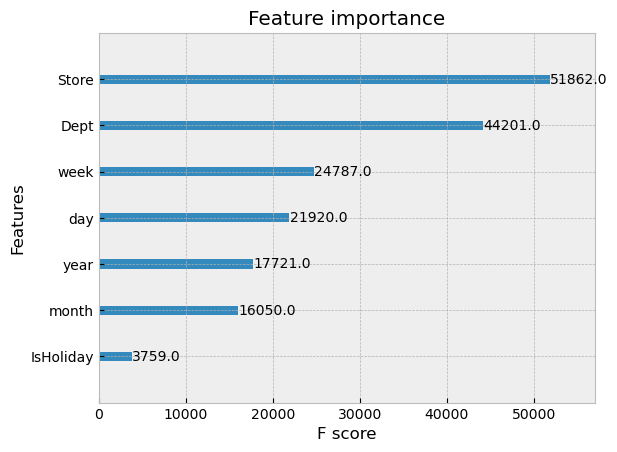

In [234]:
plot_importance(imp)
plt.show()

# Saving model

In [235]:
model = xg_gs_model
pickle.dump(model,open("Walmart-Demand-Forecasting_model.pkl","wb"))

In [236]:
model

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=7,
                   param_distributions={'max_depth': range(8, 15),
                                        'n_estimators': [10, 50],
                                        'random_state': [7, 42]},
                   verbose=2)

# Loading test data and preprocessing it

In [248]:
test = pd.read_csv("test.csv")
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [249]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [250]:
test.isna().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

No NULL values present

#### Changing all non integer values into int

1. Date column

In [251]:
# Converting it into DateTime datatype and extracting month and year
test["Date"] = pd.to_datetime(test["Date"])
test["year"] = test["Date"].dt.year
test["month"] = test["Date"].dt.month
test["week"] = test["Date"].dt.week
test["day"] = test["Date"].dt.day

2. IsHoliday column

In [252]:
# Converting T : 1 and F : 0
test["IsHoliday"] = test["IsHoliday"].astype("int64")

In [253]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  int64         
 4   year       115064 non-null  int64         
 5   month      115064 non-null  int64         
 6   week       115064 non-null  int64         
 7   day        115064 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 7.0 MB


Deleting the Date column for further predictions

In [254]:
test = test.drop(["Date"],axis=1)

In [255]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      115064 non-null  int64
 1   Dept       115064 non-null  int64
 2   IsHoliday  115064 non-null  int64
 3   year       115064 non-null  int64
 4   month      115064 non-null  int64
 5   week       115064 non-null  int64
 6   day        115064 non-null  int64
dtypes: int64(7)
memory usage: 6.1 MB


## Loading model and predicting test dataset

In [256]:
load_model = pickle.load(open("Walmart-Demand-Forecasting_model.pkl",'rb'))

In [257]:
test["predicted_Weekly_Sales"] = load_model.predict(test)

### Saving predictions

In [258]:
test["predicted_Weekly_Sales"].to_csv("predictions.csv",index=False)

# Time Series Forecasting

In [35]:
data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,month,week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,2012,10,43
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,2012,10,43
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,2012,10,43
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,2012,10,43


In [36]:
col = list(data["Weekly_Sales"])
df = pd.DataFrame(data={"Weekly_Sales":col},
                  index=data["Date"])

To analyse weekly sales, let us group data week-wise

In [37]:
df_week = df.resample('W').mean()

### Plotting Date vs Weekly sales

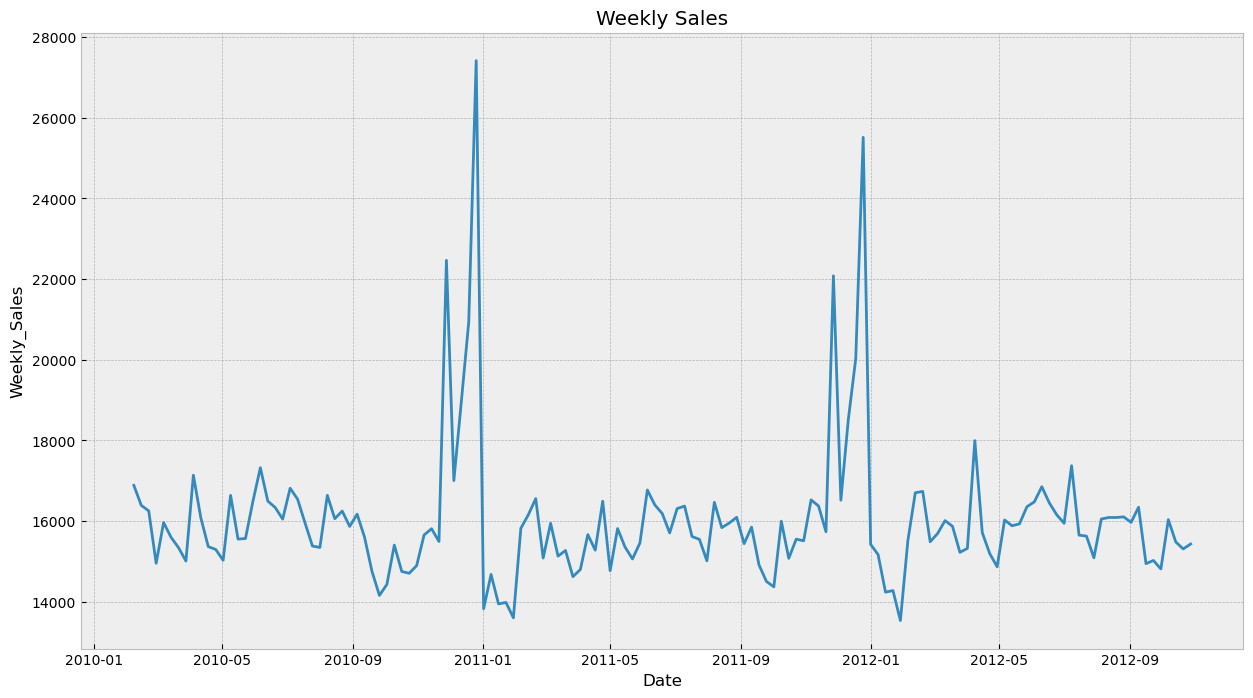

In [38]:
fig = plt.subplots(figsize=(15,8))
sns.lineplot(x="Date",y="Weekly_Sales",data=df_week,ci=None);
plt.title("Weekly Sales");

## STL Decomposition

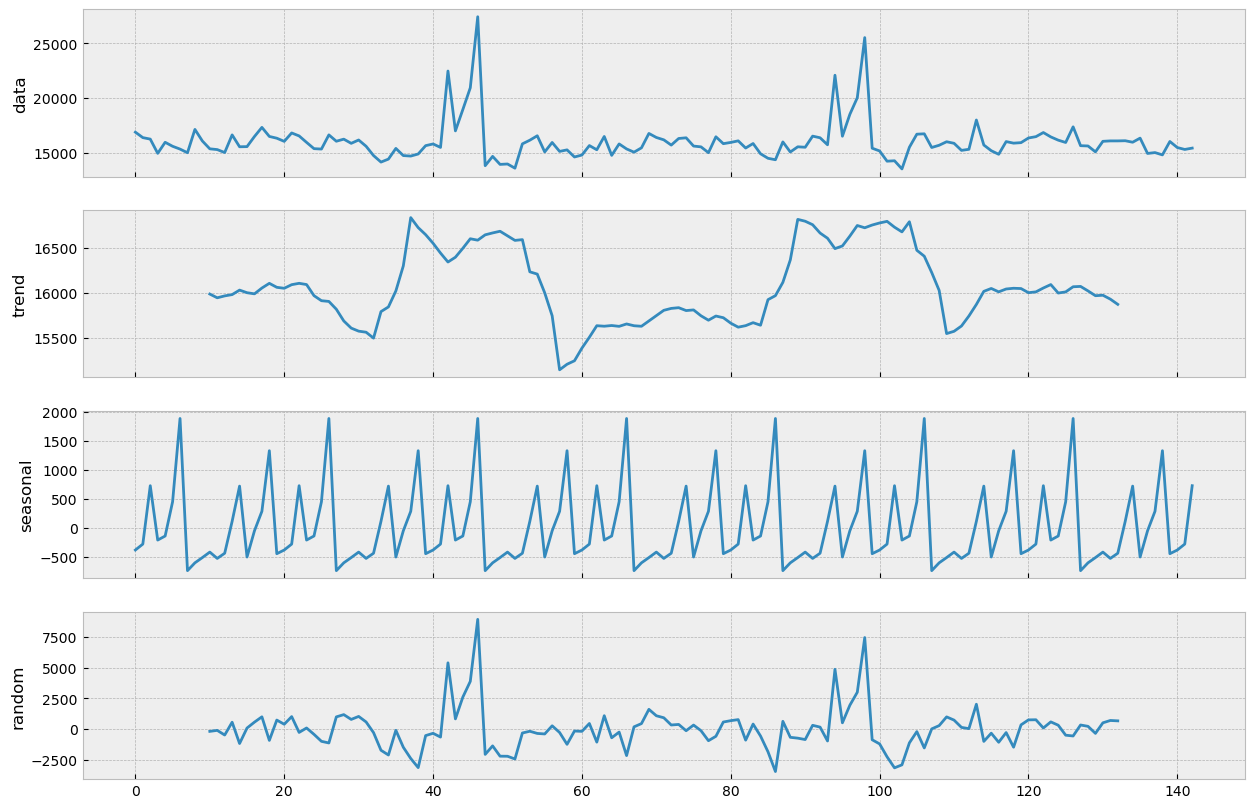

In [39]:
result = decompose(df_week["Weekly_Sales"].values,'additive',m=20)
decomposed_plot(result, figure_kwargs={'figsize':(15,10)})
plt.show();

As seen in graphs, seasonality repreats itself in every interval of 20

### Tests for non-stationary data

#### 1. Determining Rolling statistics

In [40]:
# For window size 4 to take 4 preceeding reading into mean,std calculation
rolmean = pd.DataFrame(df_week.rolling(window=4,center=False).mean())
rolstd = pd.DataFrame(df_week.rolling(window=4,center=False).std())

print("Mean\n")
print(rolmean)
print("\nSTD\n")
print(rolstd)

Mean

            Weekly_Sales
Date                    
2010-02-07           NaN
2010-02-14           NaN
2010-02-21           NaN
2010-02-28  16122.408134
2010-03-07  15891.712903
...                  ...
2012-09-30  15282.998773
2012-10-07  15206.254393
2012-10-14  15340.786172
2012-10-21  15412.268511
2012-10-28  15566.748483

[143 rows x 1 columns]

STD

            Weekly_Sales
Date                    
2010-02-07           NaN
2010-02-14           NaN
2010-02-21           NaN
2010-02-28    823.794557
2010-03-07    648.676340
...                  ...
2012-09-30    712.882863
2012-10-07    560.837947
2012-10-14    542.007315
2012-10-21    504.072643
2012-10-28    322.115847

[143 rows x 1 columns]


#### Plotting rolling statistics

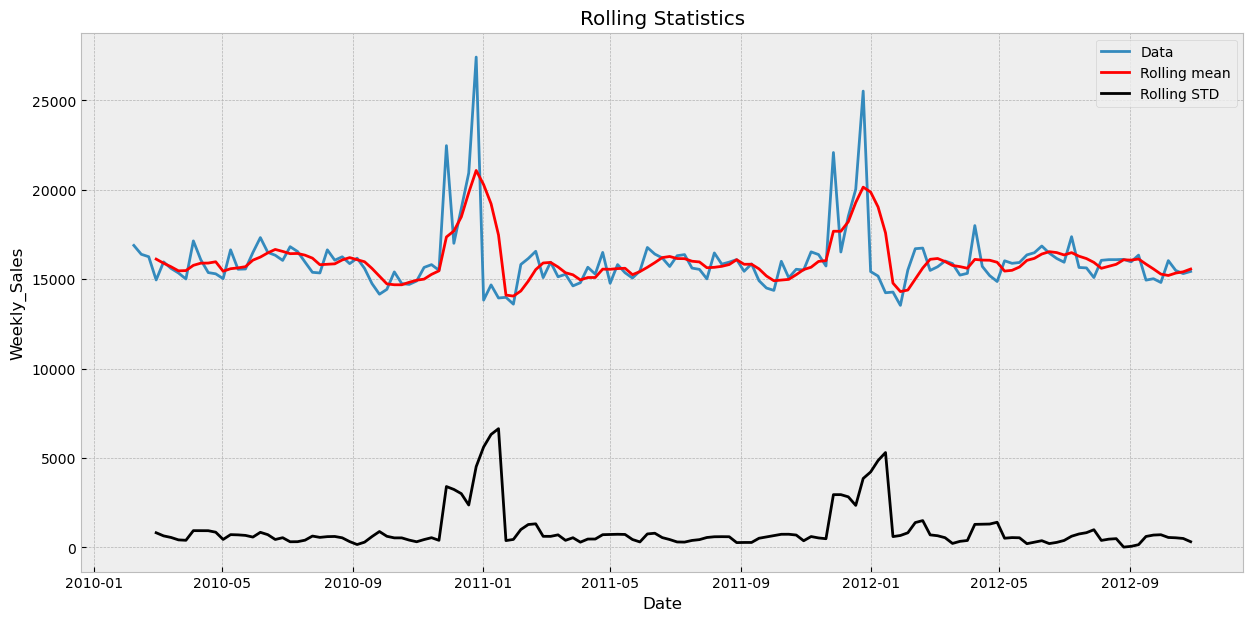

In [41]:
fig = plt.subplots(figsize=(15,7))
orig = sns.lineplot(y="Weekly_Sales",x="Date",
                    data=df_week,label="Data",ci=None)
mean = sns.lineplot(y="Weekly_Sales",x="Date",data=rolmean,
                    label="Rolling mean",ci=None,
                    color='red')
std = sns.lineplot(y="Weekly_Sales",x="Date",data=rolstd,
                   label="Rolling STD",ci=None,color='black')
plt.title("Rolling Statistics");

As our rolling mean and rolling std are not constant, our data is non-stationary

#### 2. DF test (Dickey-Fuller)

In [42]:
print("Results of Dickey-Fuller test : ")

# AIC is a (chi k) metric (analysis between what we wanted and what we got)
df_test = adfuller(df_week["Weekly_Sales"],autolag='AIC')

dfop = pd.Series(df_test[:4],index=["Test Statistics",'p-Value',
                                    'Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    dfop['Critical Value (%s)'%key]=format(value,'f')
    
print(dfop)

Results of Dickey-Fuller test : 
Test Statistics                -5.927107
p-Value                              0.0
Lags Used                            4.0
Number of Observations Used        138.0
Critical Value (1%)            -3.478648
Critical Value (5%)            -2.882722
Critical Value (10%)           -2.578065
dtype: object


Conclusion :
> * p-value is less
> * Critical values are less than Test statistics

Hence, according to ADFuller test, we can ignore the NULL hypothesis and conclude the data to be stationary

However, our rolling mean and rolling std are not constant and hence we will proceed with assuming our data is not stationary and try to make it more stationary

### Making data stationary

#### 1. Taking log() of data

In [43]:
df_week_log = np.log(df_week)

Plotting log values

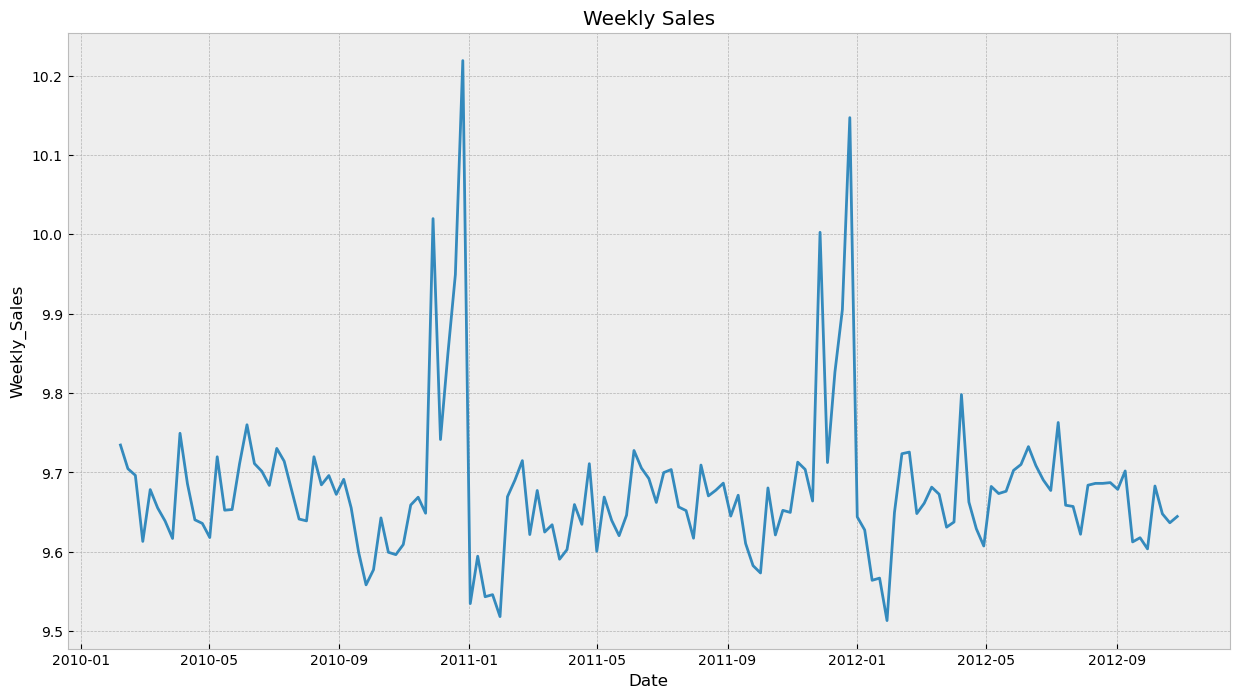

In [44]:
fig = plt.subplots(figsize=(15,8))
sns.lineplot(x="Date",y="Weekly_Sales",data=df_week_log,ci=None);
plt.title("Weekly Sales");

In [45]:
movingMean = df_week_log.rolling(window=2).mean()
movingSTD = df_week_log.rolling(window=2).std()

#### Plotting rolling stats

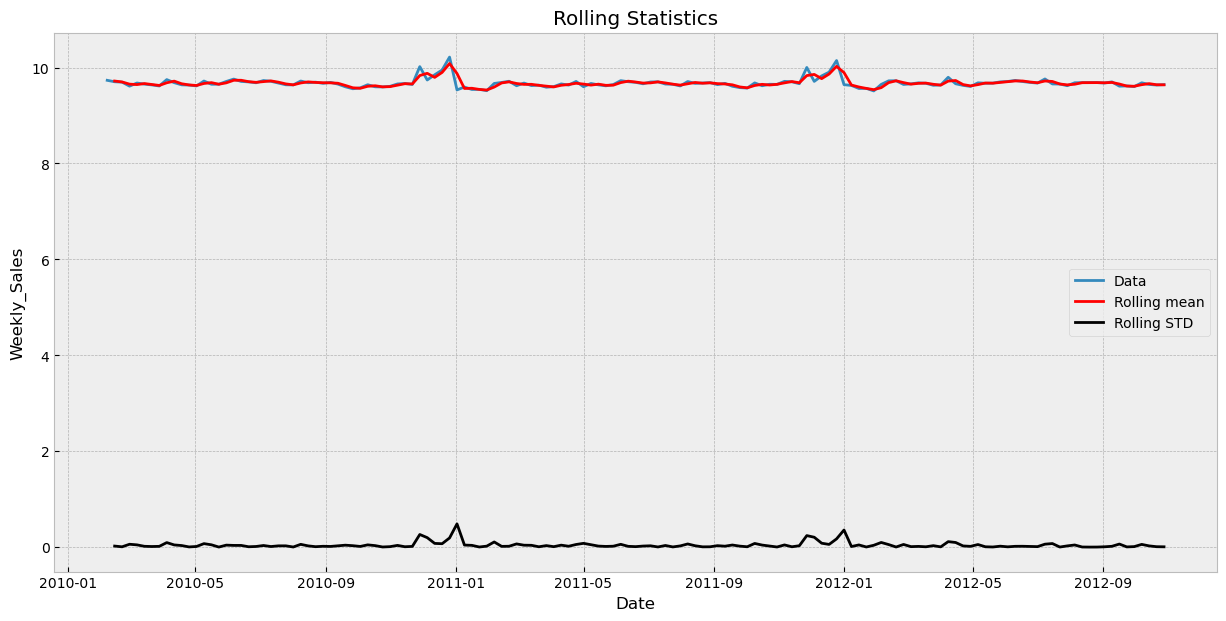

In [46]:
fig = plt.subplots(figsize=(15,7))
logged = sns.lineplot(y="Weekly_Sales",x="Date",
                    data=df_week_log,label="Data",ci=None)
m_mean = sns.lineplot(y="Weekly_Sales",x="Date",data=movingMean,
                    label="Rolling mean",ci=None,
                    color='red')
m_std = sns.lineplot(y="Weekly_Sales",x="Date",data=movingSTD,
                   label="Rolling STD",ci=None,color='black')
plt.title("Rolling Statistics");

Mean and standard deviation is almost constant!

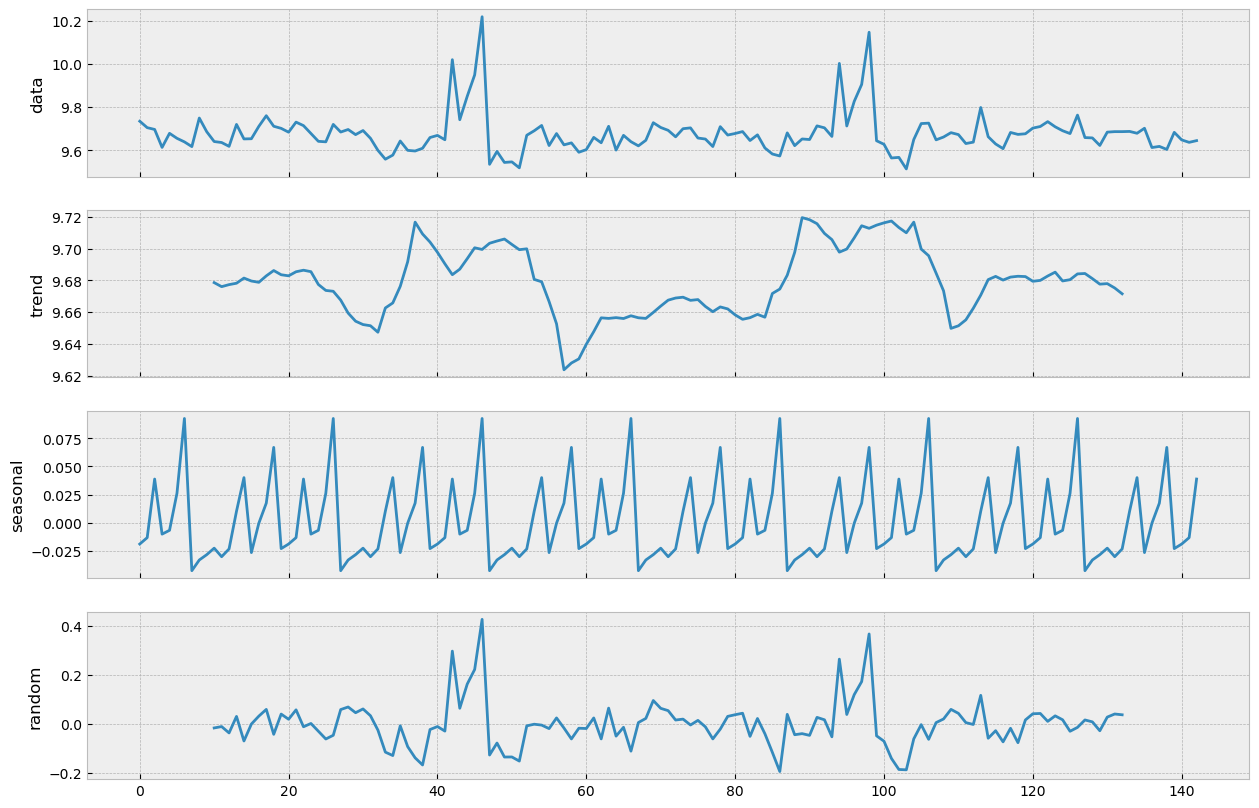

In [47]:
result_log = decompose(df_week_log["Weekly_Sales"].values,'additive',m=20)
decomposed_plot(result_log, figure_kwargs={'figsize':(15,10)})
plt.show();

Performing ADFuller test

In [48]:
print("Results of Dickey-Fuller test : ")

# AIC is a (chi k) metric (analysis between what we wanted and what we got)
df_test_log = adfuller(df_week_log["Weekly_Sales"],autolag='AIC')

df_log_op = pd.Series(df_test_log[:4],index=["Test Statistics",'p-Value',
                                    'Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    df_log_op['Critical Value (%s)'%key]=format(value,'f')
    
print(df_log_op)

Results of Dickey-Fuller test : 
Test Statistics                -6.348405
p-Value                              0.0
Lags Used                            4.0
Number of Observations Used        138.0
Critical Value (1%)            -3.478648
Critical Value (5%)            -2.882722
Critical Value (10%)           -2.578065
dtype: object


Still Conclusion :
> * p-value is less
> * Critical values are less than Test statistics

Hence, according to ADFuller test, we can ignore the NULL hypothesis and conclude the data to be stationary

#### 2. Differentiate

In [49]:
#creating difference values
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

In [50]:
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

#### Plotting rolling stats

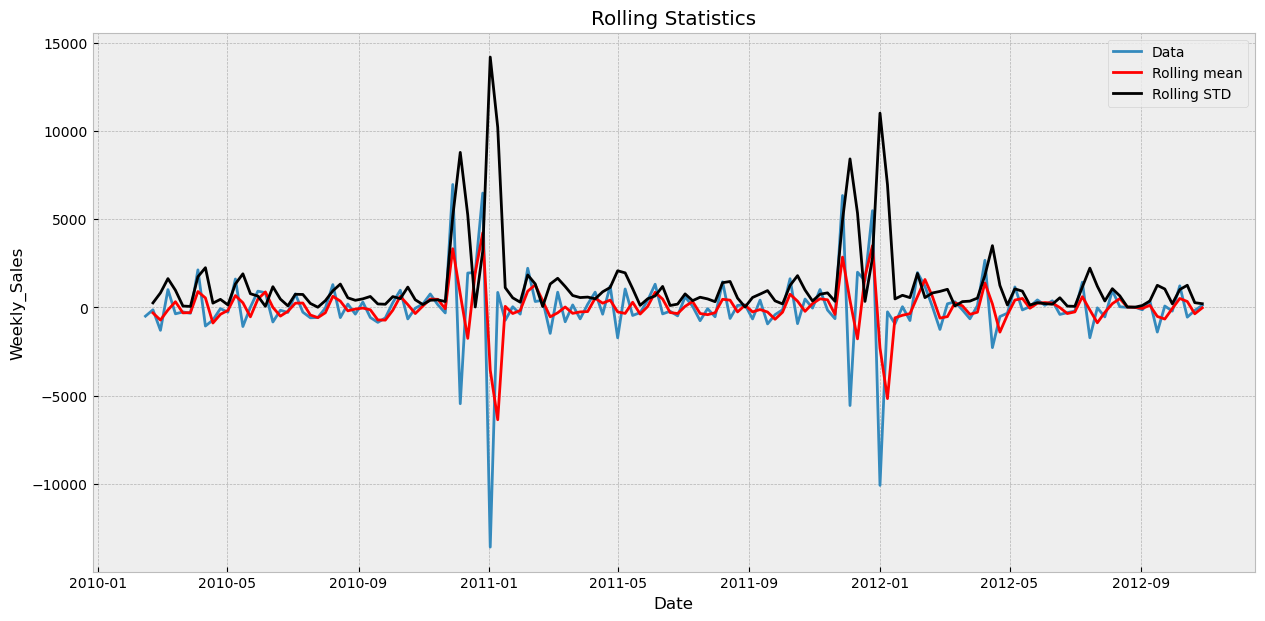

In [51]:
fig = plt.subplots(figsize=(15,7))
logged = sns.lineplot(df_week_diff,label="Data",ci=None)
m_mean = sns.lineplot(diff_roll_mean,
                    label="Rolling mean",ci=None,
                    color='red')
m_std = sns.lineplot(diff_roll_std,
                   label="Rolling STD",ci=None,color='black')
plt.title("Rolling Statistics");

Performing ADFuller test

In [61]:
print("Results of Dickey-Fuller test : ")

# AIC is a (chi k) metric (analysis between what we wanted and what we got)
df_test_diff = adfuller(df_week_diff,autolag='AIC')

df_diff_op = pd.Series(df_test_diff[:4],index=["Test Statistics",'p-Value',
                                    'Lags Used','Number of Observations Used'])
for key,value in df_test_diff[4].items():
    df_diff_op['Critical Value (%s)'%key]=format(value,'f')
    
print(df_diff_op)

Results of Dickey-Fuller test : 
Test Statistics                -6.674884
p-Value                              0.0
Lags Used                            7.0
Number of Observations Used        134.0
Critical Value (1%)            -3.480119
Critical Value (5%)            -2.883362
Critical Value (10%)           -2.578407
dtype: object


#### 3. Shifting data

In [53]:
df_week_lag = df_week["Weekly_Sales"].shift(3).dropna()

In [54]:
lag_rolmean = df_week_lag.rolling(window=2,center=False).mean()
lag_rolstd = df_week_lag.rolling(window=2,center=False).std()

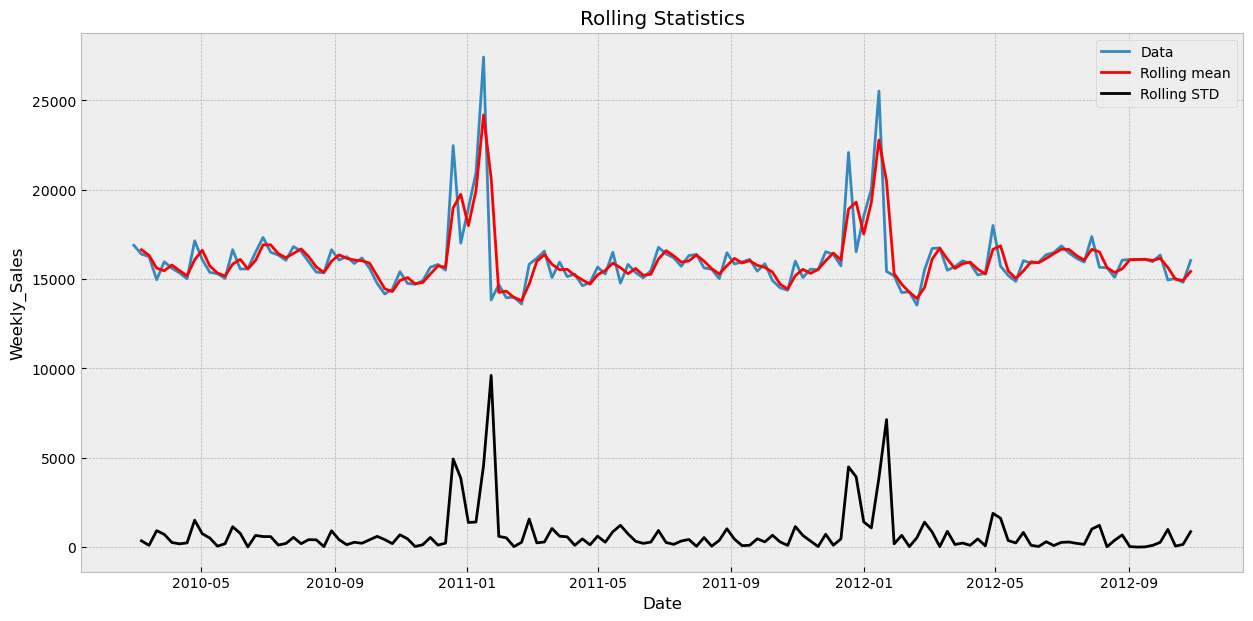

In [55]:
fig = plt.subplots(figsize=(15,7))
logged = sns.lineplot(df_week_lag,label="Data",ci=None)
m_mean = sns.lineplot(lag_rolmean,
                    label="Rolling mean",ci=None,
                    color='red')
m_std = sns.lineplot(lag_rolstd,
                   label="Rolling STD",ci=None,color='black')
plt.title("Rolling Statistics");

#### 4. Taking differenced data - rolling mean

In [56]:
df_diff_avg = (df_week_diff - diff_roll_mean).dropna()

In [57]:
df_diffavg_mean = df_diff_avg.rolling(window=2,center=False).mean()
df_diffavg_std = df_diff_avg.rolling(window=2,center=False).std()

#### Plotting Rolling statistics

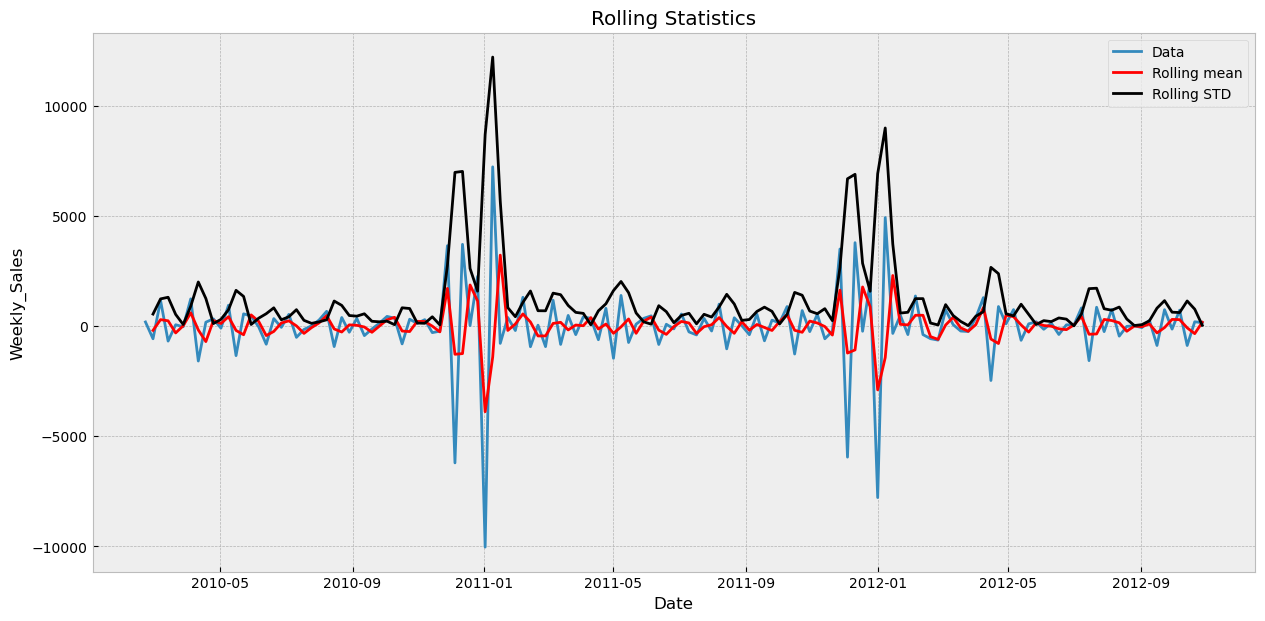

In [58]:
fig = plt.subplots(figsize=(15,7))
logged = sns.lineplot(df_diff_avg,label="Data",ci=None)
m_mean = sns.lineplot(df_diffavg_mean,
                    label="Rolling mean",ci=None,
                    color='red')
m_std = sns.lineplot(df_diffavg_std,
                   label="Rolling STD",ci=None,color='black')
plt.title("Rolling Statistics");

Results of ADFuller test

In [63]:
print("Results of Dickey-Fuller test : ")

# AIC is a (chi k) metric (analysis between what we wanted and what we got)
df_test_diffavg = adfuller(df_diff_avg,autolag='AIC')

df_diffavg_op = pd.Series(df_test_diffavg[:4],index=["Test Statistics",'p-Value',
                                    'Lags Used','Number of Observations Used'])
for key,value in df_test_diffavg[4].items():
    df_diffavg_op['Critical Value (%s)'%key]=format(value,'f')
    
print(df_diffavg_op)

Results of Dickey-Fuller test : 
Test Statistics                -6.919315
p-Value                              0.0
Lags Used                           10.0
Number of Observations Used        130.0
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: object


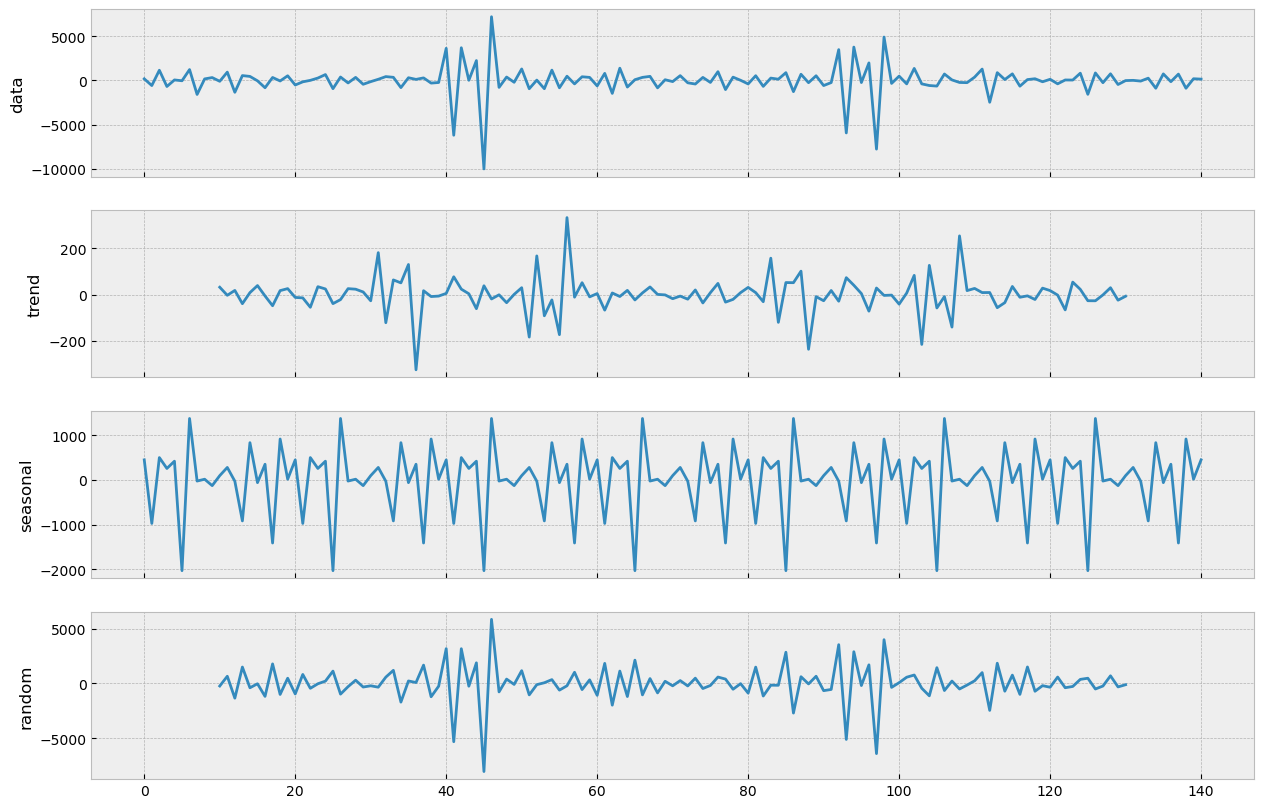

In [64]:
result_seasoned = decompose(df_diff_avg.values,'additive',m=20)
decomposed_plot(result_seasoned,figure_kwargs={'figsize':(15,10)})
plt.show();

Hence, we can conclude that our data is now stationary

## ARIMA MODEL

We achieved stationary data by taking log , so I am going to use logged data for further analysis

Dividing into train and test sets
* 75% Training
* 25% Testing

In [65]:
train = df_diff_avg[:int(0.7*len(df_diff_avg))]
test = df_diff_avg[int(0.7*len(df_diff_avg)):]

We will use auto_arima feature to get the best p,d,q and P,D,Q values

In [ ]:
model_auto_arima = auto_arima(df_diff_avg, trace=True,start_p=0, start_q=0,n_fit=10, start_P=1, start_Q=1,
                  max_p=20, max_q=20, max_P=20, max_Q=20,seasonal=True,seasonal_order=(1,1,1,1),
                  maxiter=100,stepwise=True, suppress_warnings=True,D=1, max_D=10,m=52,
                  error_action='ignore')
results = model_auto_arima.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=7.95 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1412.345, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1361.105, Time=3.85 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=5.56 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1410.351, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1373.980, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=inf, Time=15.02 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=12.33 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1359.704, Time=5.41 sec
 ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=inf, Time=28.31 sec
 ARIMA(1,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=51.46 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1399.594, Time=3.23 sec
 ARIMA(2,0,0)(0,1,1)[52] intercept   : AIC=1341.831, Time=6.06 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=1356.825, Time=0.34 sec
 ARIMA(2,0,0)(1,1,1)[52] intercept   : AIC=in

In [272]:
#Predicting testing dataset
y_pred = model_auto_arima.predict(n_periods=len(test))
y_pred = pd.DataFrame(y_pred,index = test.index,columns=['Prediction'])

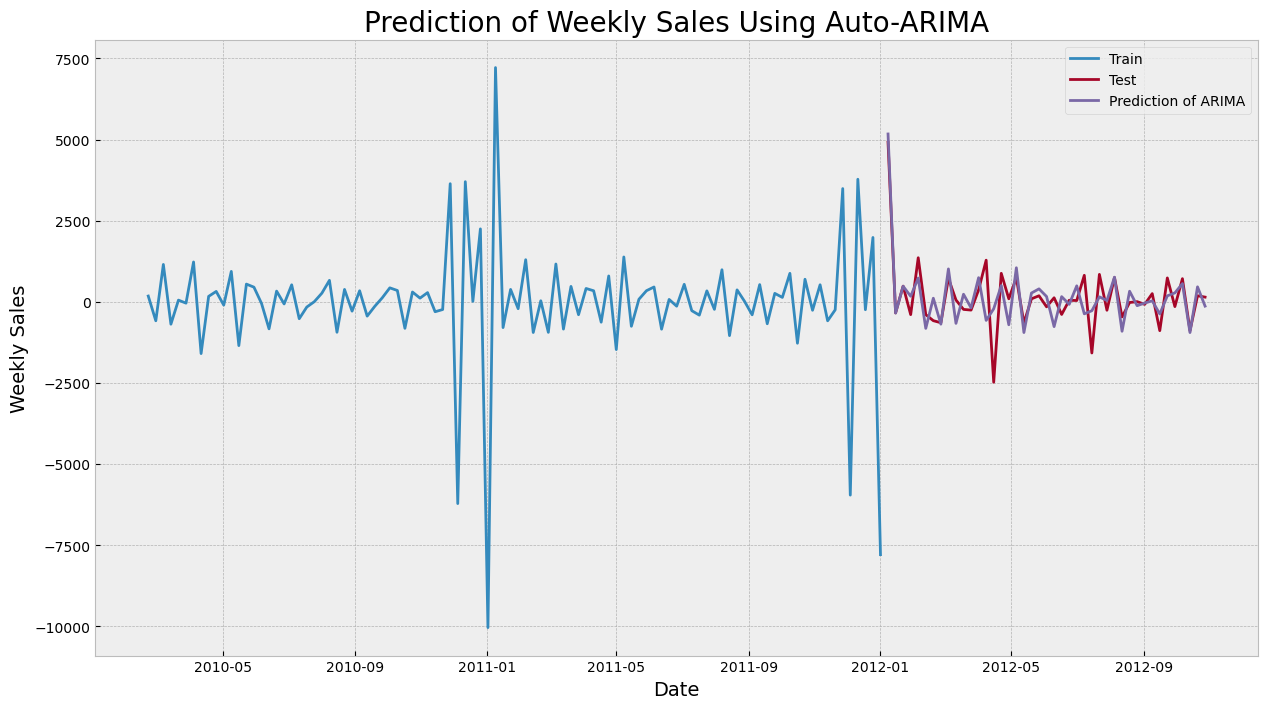

In [273]:
fig = plt.subplots(figsize=(15,8))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

As RSS score is very small, Our ARIMA model as fitted well.

In [275]:
mean_absolute_percentage_error(y_pred,test)

1.8787045975265406

# Predicting Sales for next 3 years

In [276]:
df_week

,Weekly_Sales
Date,
2010-02-07,16887.602166
2010-02-14,16390.912208
2010-02-21,16255.185970
2010-02-28,14955.932194
2010-03-07,15964.821240
...,...
2012-09-30,14815.621125
2012-10-07,16037.442175
2012-10-14,15484.696200


* Steps = 52*3 = 156 (52 weeks in 1 year predicting for 3 years)
* Hence total predictions = 143+156 = 299

In [277]:
res = results.predict(160)

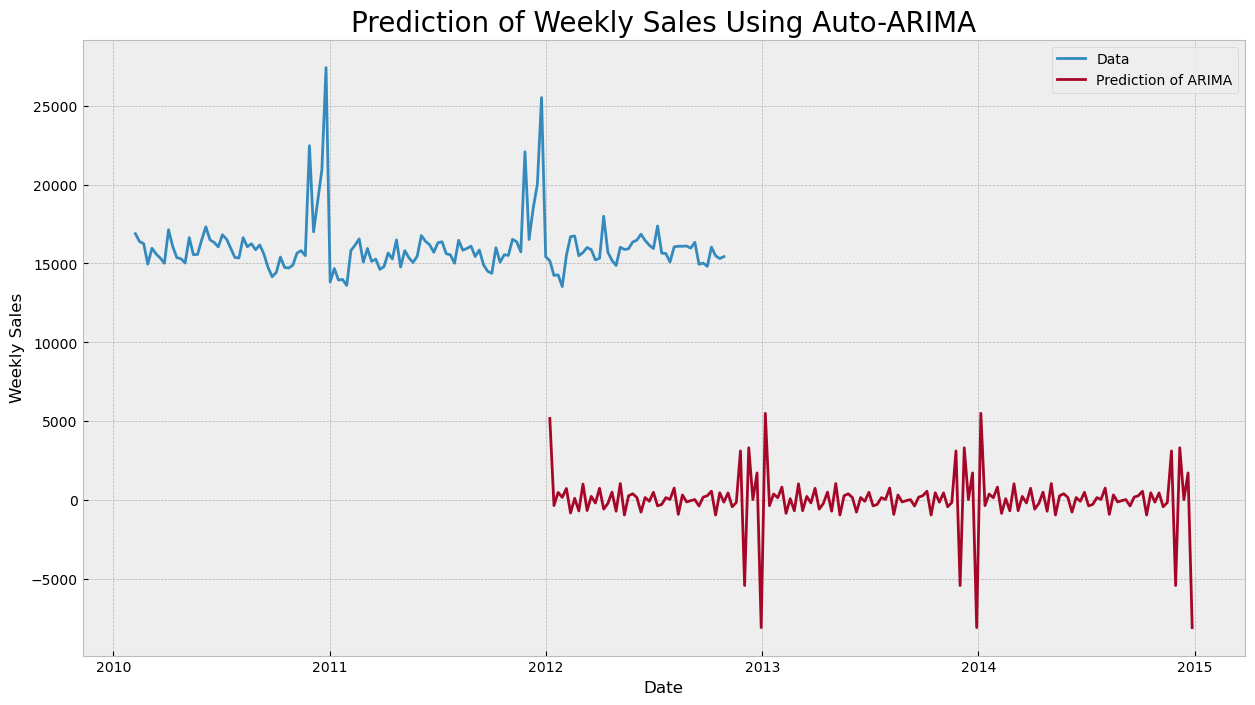

In [285]:
fig = plt.subplots(figsize=(15,8))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(df, label='Data')
plt.plot(test, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.plot(res,label="Prediction of ARIMA")
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [281]:
res.cumsum()

2012-01-08    5173.472299
2012-01-15    4828.866102
2012-01-22    5312.092653
2012-01-29    5486.559161
2012-02-05    6221.897783
                 ...     
2014-11-30    3571.675887
2014-12-07    6887.850120
2014-12-14    6920.291582
2014-12-21    8643.456319
2014-12-28     563.055578
Freq: W-SUN, Length: 156, dtype: float64